In [1]:
import os

import pickle
import torch
import torch.nn as nn
from torch import dtype as T_dtype
from torch.quantization import get_default_qconfig
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
from torch.utils.data.dataloader import DataLoader

from utils import (
    count_nonzero_parameters,
    get_device,
    get_model_size_mb,
    get_test_cifar10_dataloader,
    load_trained_model,
    test,
)

In [1]:
QCONFIG = get_default_qconfig('fbgemm')
QCONFIG_DEFAULT = {
    "": QCONFIG,
    "object_type": [
        (torch.nn.Conv2d, QCONFIG),
        (torch.nn.Linear, QCONFIG),
        (torch.nn.ReLU, QCONFIG),
        (torch.nn.BatchNorm2d, QCONFIG),
    ]
}

def quantise_dynamic(
        model: nn.Module,
        spec: tuple = {torch.nn.Linear},
        dtype: T_dtype = torch.qint8,
    ) -> nn.Module:
    return torch.quantization.quantize_dynamic(
        model, spec, dtype=dtype,
    )

def quantise_static(
        model: nn.Module,
        calibration_loader: DataLoader,
        qconfig_dict: dict = QCONFIG_DEFAULT,
    ) -> nn.Module:
    model = model.to('cpu')
    example_inputs = (next(iter(calibration_loader))[0],)
    prepared_model = prepare_fx(model, qconfig_dict, example_inputs)
    return convert_fx(prepared_model)

NameError: name 'get_default_qconfig' is not defined

In [3]:
test_loader = get_test_cifar10_dataloader()
device = get_device()

### No Quantisation

In [4]:
model, og_acc = load_trained_model()
og_size = get_model_size_mb(model)

### Dynamic Quantisation

In [5]:
model.to("cpu")
dynamic_quantised_model = torch.quantization.quantize_dynamic(
        model, {torch.nn.Linear}, dtype=torch.qint8,
    )
dynamic_quantised_size = get_model_size_mb(dynamic_quantised_model)

dynamic_quantised_acc, _ = test(
    test_loader,
    dynamic_quantised_model,
    device="cpu"
)

In [6]:
print(f"Dynamic quantisation size: {dynamic_quantised_size} (MB)")
print(f"Dynamic quantisation accuracy: {dynamic_quantised_acc}")

Dynamic quantisation size: 28.314057 (MB)
Dynamic quantisation accuracy: 90.44


### Static Quantisation

In [7]:
model.eval() 
static_quantised_model = quantise_static(model, test_loader)
static_quantised_size = get_model_size_mb(static_quantised_model)

static_quantised_model.to("cpu")
static_quantised_acc, _ = test(
    test_loader,
    static_quantised_model,
    device="cpu"
)

print(f"Static quantisation size: {static_quantised_size} (MB)")
print(f"Static quantisation accuracy: {static_quantised_acc}")

/users/local/b24richa/EfficientDeepLearning/.venv/lib/python3.12/site-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping instead.
  prepared = prepare(
/users/local/b24richa/EfficientDeepLearning/.venv/lib/python3.12/site-packages/torch/ao/quantization/observer.py:244: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/users/local/b24richa/EfficientDeepLearning/.venv/lib/python3.12/site-packages/torch/ao/quantization/observer.py:1333: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


Static quantisation size: 7.896661 (MB)
Static quantisation accuracy: 10.0


### 16 bit quantisation

In [8]:
model = model.to(device)
half_model = model.half()
half_model_size = get_model_size_mb(half_model)

half_model_acc, _ = test(
    test_loader,
    half_model,
    half=True
)

print(f"16 bit quantisation size: {half_model_size} (MB)")
print(f"16 bit quantisation accuracy: {half_model_acc}")

16 bit quantisation size: 14.274451 (MB)
16 bit quantisation accuracy: 90.42


### Binary quantisation

In [12]:
with open("quantisation/bc_test_acc.pkl", "rb") as f:
    bin_res = pickle.load(f)

bc_model = bin_res["bc_model"]
bc_test_acc = bin_res["bc_test_acc"]
bc_estimated_quant = (
    count_nonzero_parameters(bc_model) / (8 * 1048576)
)

print(f"Binary quantisation size: {bc_estimated_quant:2f} (MB)")
print(f"Binary quantisation accuracy: {bc_test_acc}")

Binary quantisation size: 0.829255 (MB)
Binary quantisation accuracy: 81.89


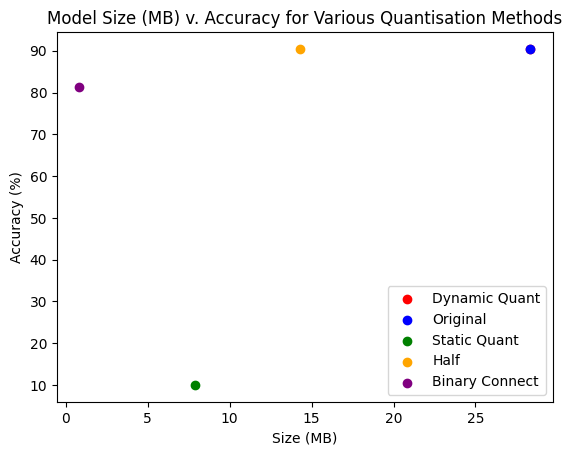

In [10]:
import matplotlib.pyplot as plt

x = [
    og_size,
    dynamic_quantised_size,
    static_quantised_size,
    half_model_size,
    bc_estimated_quant,
]
y = [
    og_acc,
    dynamic_quantised_acc, 
    static_quantised_acc,
    half_model_acc,
    bc_test_acc,
]

labels = ['Dynamic Quant', 'Original','Static Quant', 'Half', 'Binary Connect']
colors = ['red', 'blue', 'green', 'orange', 'purple']

for xi, yi, label, color in zip(x, y, labels, colors):
    plt.scatter(xi, yi, label=label, color=color)

plt.xlabel("Size (MB)")
plt.ylabel("Accuracy (%)")
plt.title("Model Size (MB) v. Accuracy for Various Quantisation Methods")
plt.legend()